# Find line for break in slope

## First find which RGT's were captured for which cycles

All of this information is dumped into a large dictionary

In [1]:
import os
import shapely as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from time import time as Time
import ICESat2GroundingLineMigration.IceSatHDF5Unpacker as unpack
import src.TrackProfileUtil as util
import src.SlopeBreak2 as slpbr
pd.options.mode.chained_assignment = None

In [2]:
allpaths = os.listdir("Saves")
rgts = sorted([int(path) for path in allpaths if "." not in list(path)])

In [3]:
names = ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]
cycles = list(range(1, 19))
directory = {rgt:{name:[] for name in names} for rgt in rgts}

In [4]:
for i, rgt in enumerate(rgts):
    for name in names:
        for cycle in cycles:
            filepath = f"Saves/{rgt}/{name}/Bung-{cycle}.json"
            print(f"Checking paths for rgt: {rgt}-{name}-{cycle}", end="    \r")
            if os.path.isfile(filepath) == True:
                directory[rgt][name].append(cycle)

#
# Find Ib for each track in a given cycle

## First find which tracks are in that cycle

In [5]:
cycle = 5
fullset = []

In [6]:
for rgt in rgts:
    for name in names:
        if cycle in directory[rgt][name]:
            fullset.append(f"{rgt}-{name}")

## Prep other necessary items

In [7]:
study_area, lim = slpbr.studyArea("Bounds/bungen.gpkg")
xlim, ylim = lim

In [8]:
basemap = unpack.Basemap("BackgroundData/GroundedIce.gpkg")
gline_xy = util.gline_to_df(basemap.basemap_gpd, study_area)

## Open up and compute for each track

In [9]:
ibs = pd.DataFrame(columns=["x","y","time","cyc", "track", "direc", "ahead_x", "ahead_y", "behind_x", "behind_y"])

In [10]:
def find_near(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return int(idx)

In [11]:
tot = len(fullset)
starttime = Time()
for i, item in enumerate(fullset):
    rgt, name = item.split("-")
    path = f"Saves/{rgt}/{name}/Bung-{cycle}.json"
    print(f"{i}/{tot} ({round(i/tot*100, 2)}%) | Opening {rgt}-{name}-{cycle} | TotTime: {round((Time()-starttime)/60, 2)}min EstTime: {round(((Time()-starttime)/60) * (tot/(i+0.0001)) - (Time()-starttime)/60, 2)}min", end="        \r")
    track = gpd.read_file(path)
    print(f"{i}/{tot} ({round(i/tot*100, 2)}%) | Find Ib {rgt}-{name}-{cycle} | TotTime: {round((Time()-starttime)/60, 2)}min EstTime: {round(((Time()-starttime)/60) * (tot/(i+0.0001)) - (Time()-starttime)/60, 2)}min", end="        \r")
    out = slpbr.findIb(track, gline_xy)
    boolib = False
    try:
        track, ib, direc = out
        d_min = track["along_dist"].min() + 0.5
        d_max = track["along_dist"].max() - 0.5
        nearest_id = find_near(track["along_dist"], ib)
        xy = (track.iloc[nearest_id]["x"], track.iloc[nearest_id]["y"])
        ahead = (track.iloc[nearest_id + 50]["x"], track.iloc[nearest_id + 50]["y"])
        behind = (track.iloc[nearest_id - 50]["x"], track.iloc[nearest_id - 50]["y"])
        time = track.iloc[nearest_id]["date_time"]
        ibs.loc[-1] = {"x":xy[0], "y":xy[1], "time":time, "cyc":cycle, "track":item, "direc":direc, "ahead_x":ahead[0], "ahead_y":ahead[1], "behind_x":behind[0], "behind_y":behind[1]}  # adding a row
        ibs.index = ibs.index + 1  # shifting index
        ibs = ibs.sort_index()  # sorting by index
        boolib = True
    except:
        track = out

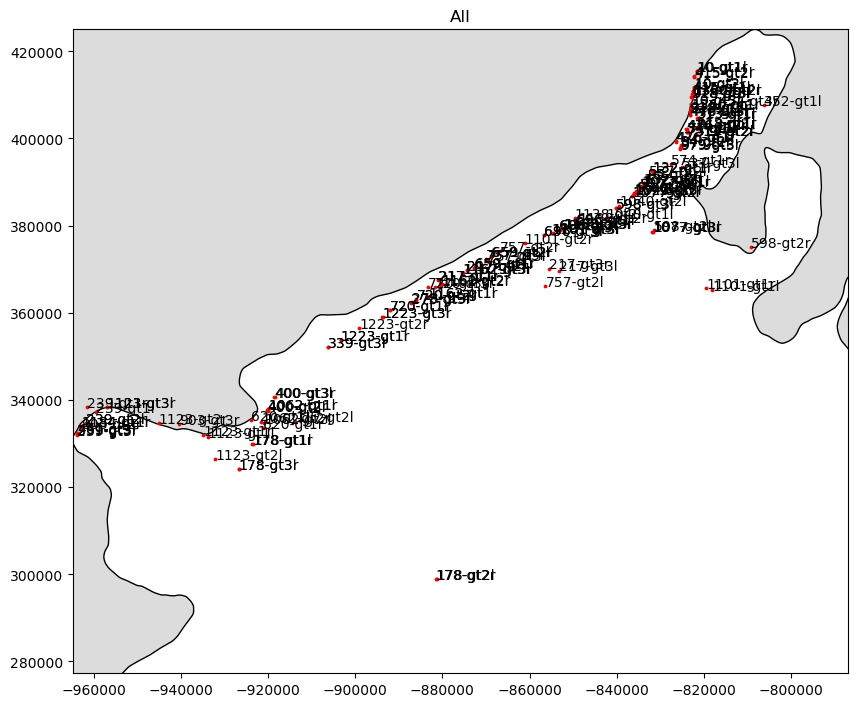

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")
    
direc_clrs = ['blue', 'red']
for i in range(len(ibs)):
    row = ibs.iloc[i]
    plt.scatter(row["x"], row["y"], s = 3, color="red")
    plt.text(row["x"], row["y"], row["track"])
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()

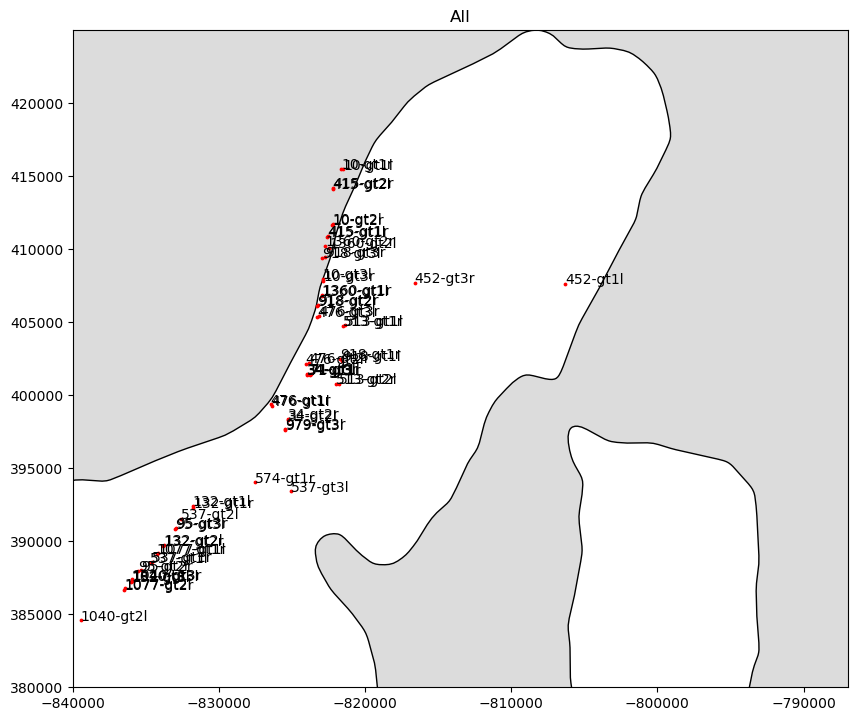

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")
    
for i in range(len(ibs)):
    row = ibs.iloc[i]
    plt.scatter(row["x"], row["y"], s = 3, color="red")
    if row["x"] > -840000 and row["y"] > 380000:
        plt.text(row["x"], row["y"], row["track"])
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(-840000, gline_xy["x"].max())
plt.ylim(380000, gline_xy["y"].max())
    
plt.show()

In [15]:
ibs.to_csv(f"Line/{cycle}-Ib.csv")

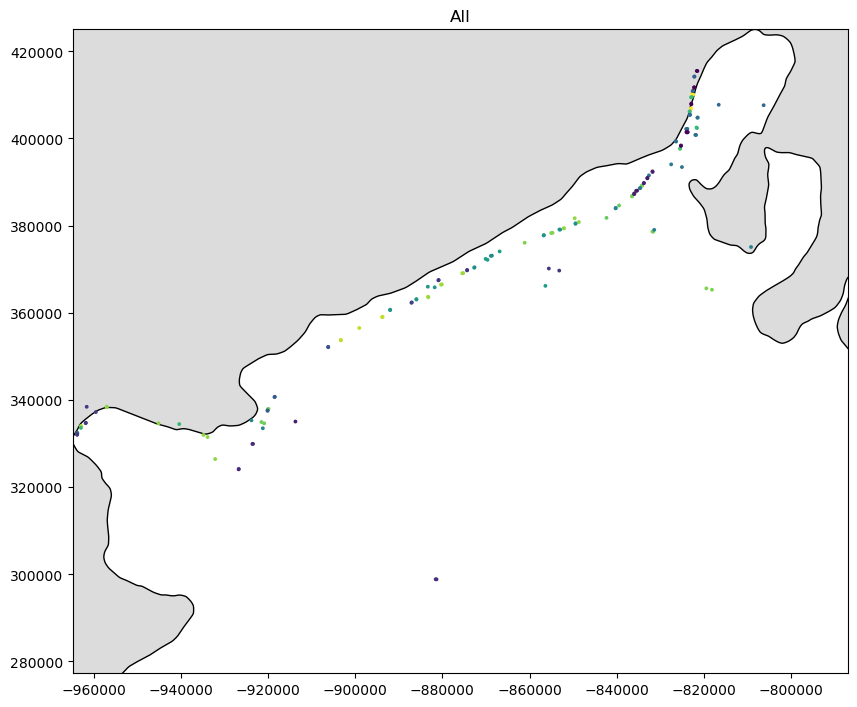

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")
    
plt.scatter(ibs["x"], ibs["y"], s = 3, c=ibs["time"])
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()

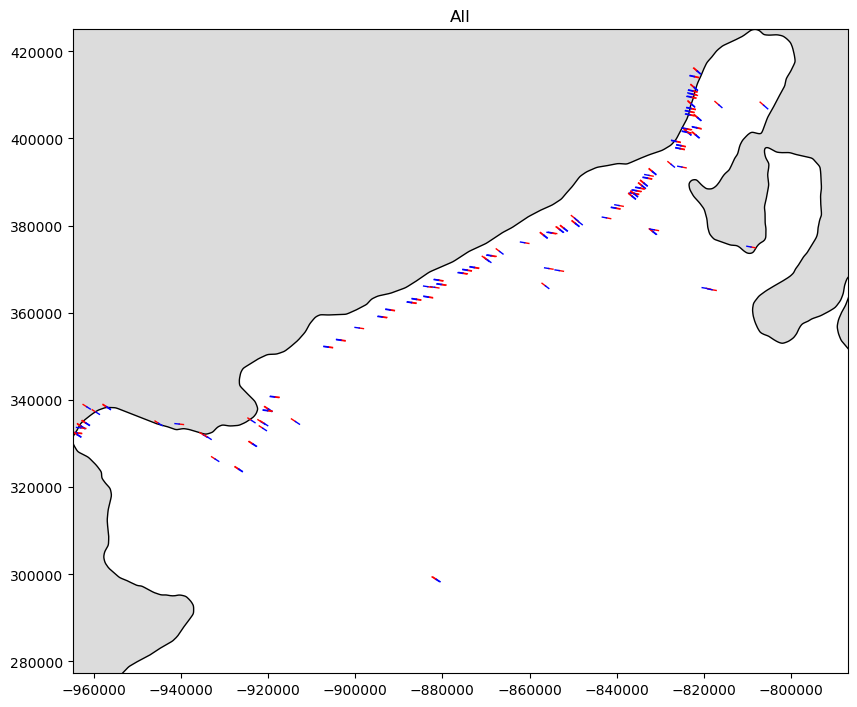

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")
    
direc_clrs = ['blue', 'red']
for i in range(len(ibs)):
    row = ibs.iloc[i]
    if direc == 111:
        plt.plot([row["x"], row["behind_x"]], [row["y"], row["behind_y"]], linewidth = 1, color='blue')
        plt.plot([row["x"], row["ahead_x"]], [row["y"], row["ahead_y"]], linewidth = 1, color='red')
    else:
        plt.plot([row["x"], row["behind_x"]], [row["y"], row["behind_y"]], linewidth = 1, color='red')
        plt.plot([row["x"], row["ahead_x"]], [row["y"], row["ahead_y"]], linewidth = 1, color='blue')
    #plt.text(row["x"], row["y"], row["track"])
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()